In [5]:
import pandas as pd
df = pd.read_csv('Alcohol_Sales.csv', index_col = 'DATE', parse_dates = True)
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<AxesSubplot: xlabel='DATE'>

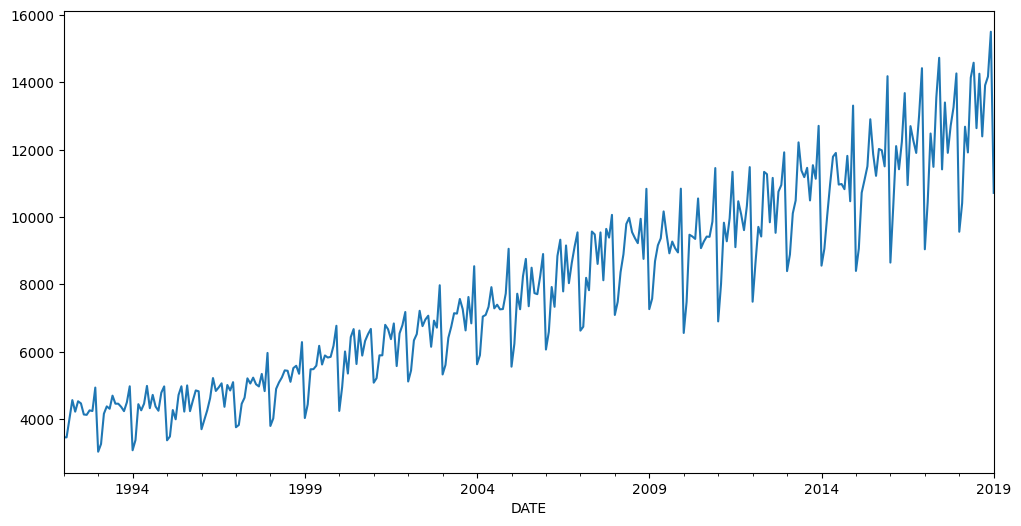

In [6]:
df['Sales'].plot(figsize = (12,6))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
df.index.freq = 'MS'

result = seasonal_decompose(df['Sales'])

<AxesSubplot: xlabel='DATE'>

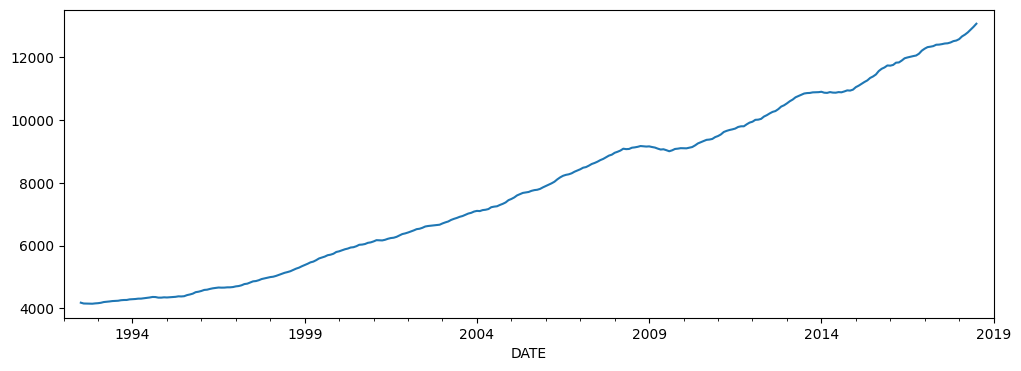

In [8]:
result.trend.plot(figsize = (12,4))

<AxesSubplot: xlabel='DATE'>

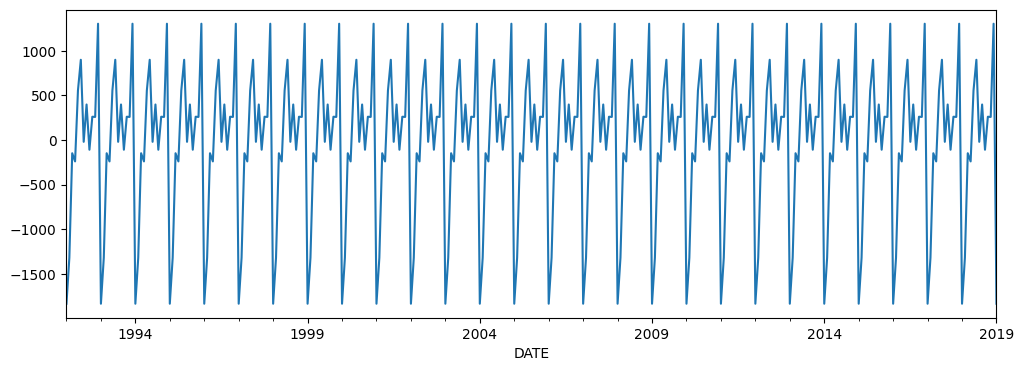

In [9]:
result.seasonal.plot(figsize = (12,4))

<AxesSubplot: xlabel='DATE'>

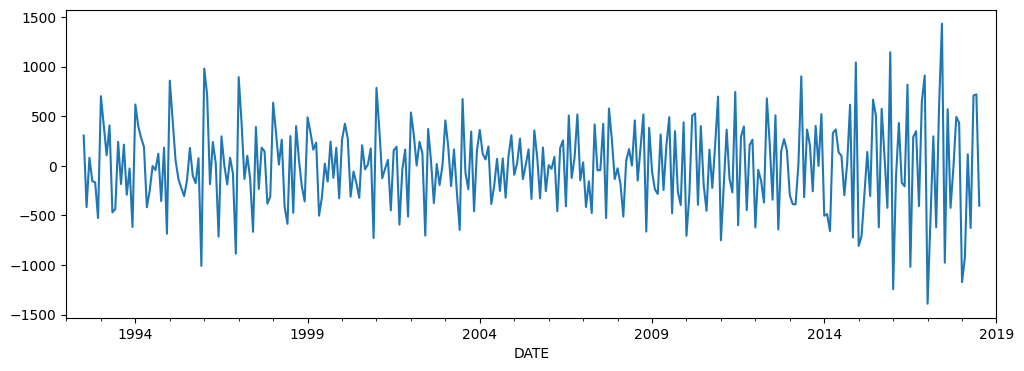

In [10]:
result.resid.plot(figsize = (12,4))

In [11]:
# train/test split
# scaling
# modeling(compile, fit)
# model evaluate

# train/test split

In [12]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [13]:
df.shape

(325, 1)

In [16]:
print(df.index.min())
print(df.index.max())

1992-01-01 00:00:00
2019-01-01 00:00:00


<AxesSubplot: xlabel='DATE'>

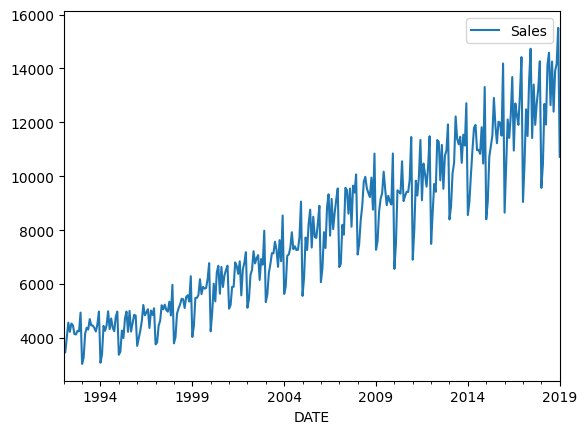

In [21]:
df.plot()

In [25]:
# 12, 24 , 36 , seasonal 하니 36으로

In [27]:
test_size = 36
split_idx = len(df) - test_size

train = df.iloc[:split_idx]
test = df.iloc[split_idx : ]
print(train.shape)
print(test.shape)


(289, 1)
(36, 1)


# scaling

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

순환신경망에 넣기 위해서는 scaled_train을 바꿔줘야한다. <br>
그래서 변환시켜주는게 Test TimeseriesGenerator

### Test TimeseriesGenerator

In [43]:
import tensorflow as tf

window_size = 2
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length = window_size, batch_size = 1)


In [34]:
scaled_train[:5]

array([[0.03837877],
       [0.0382891 ],
       [0.08706958],
       [0.13746413],
       [0.10670732]])

In [42]:
for i in range(10):
    x, y = generator[i]
    print(f'input: {x.flatten()}', f'target: {y}')

input: [0.03837877 0.0382891 ] target: [[0.08706958]]
input: [0.0382891  0.08706958] target: [[0.13746413]]
input: [0.08706958 0.13746413] target: [[0.10670732]]
input: [0.13746413 0.10670732] target: [[0.13432568]]
input: [0.10670732 0.13432568] target: [[0.12867647]]
input: [0.13432568 0.12867647] target: [[0.09917504]]
input: [0.12867647 0.09917504] target: [[0.09818867]]
input: [0.09917504 0.09818867] target: [[0.11011478]]
input: [0.09818867 0.11011478] target: [[0.10841105]]
input: [0.11011478 0.10841105] target: [[0.17082138]]


In [44]:
# 12개월 데이터를 input -> 1개월 데이터를 예측 (target)

window_size = 12
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length = window_size, batch_size = 1)


# modeling(compile, fit)

바로위의 변환데이터를 받아와서

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (window_size, 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(generator, epochs = 50)


Epoch 1/50
277/277 [==============================] - 5s 8ms/step - loss: 0.0175
Epoch 2/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0095
Epoch 3/50
277/277 [==============================] - 2s 9ms/step - loss: 0.0092
Epoch 4/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0084
Epoch 5/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 6/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0079
Epoch 7/50
277/277 [==============================] - 2s 9ms/step - loss: 0.0069
Epoch 8/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0063
Epoch 9/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0046
Epoch 10/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0037
Epoch 11/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0033
Epoch 12/50
277/277 [==============================] - 2s 8ms/step - loss: 0.0030
Epoch 13/50
277/277 [====

# model evaluate(평가)

왜하냐면, 일반화가 잘되었는지 확인하기 위해서!

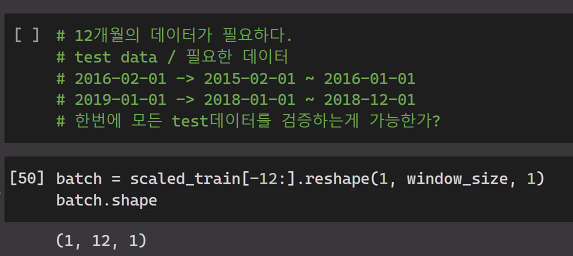

In [49]:
print(train.index.min())
print(train.index.max())
print(test.index.min())
print(test.index.max())

1992-01-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2019-01-01 00:00:00


In [ ]:
# 모델의 결과를 for문으로 작성하고 scaled_test와 비교

In [50]:
# 12개월의 데이터가 필요하다.
# test data / 필요한 데이터
# 2016-02-01 -> 2015-02-01 ~ 2016-01-01
# 2019-01-01 -> 2018-01-01 ~ 2018-12-01
# 한번에 모든 test데이터를 검증하는게 가능한가?

In [51]:
# 2016-02-01
batch = scaled_train[-12:].reshape(1, window_size, 1)
batch.shape

(1, 12, 1)

In [52]:
model.predict(batch)

1/1 [==============================] - 0s 334ms/step


array([[0.62093616]], dtype=float32)

In [53]:
scaled_test[0]

array([0.6536944])

In [54]:
# 2016-03-01
scaled_train[-11:]

array([[0.68965208],
       [0.72417504],
       [0.76013271],
       [0.88531205],
       [0.79250359],
       [0.73466643],
       [0.8062231 ],
       [0.80272597],
       [0.75995337],
       [1.        ],
       [0.50367647]])

In [55]:
import numpy as np
batch2 = np.append(scaled_train[-11:], [scaled_test[0]])
batch2.shape
print(batch2)

[0.68965208 0.72417504 0.76013271 0.88531205 0.79250359 0.73466643
 0.8062231  0.80272597 0.75995337 1.         0.50367647 0.6536944 ]
